<a href="https://colab.research.google.com/github/YeonjeeJung/LearningRateStudy/blob/master/constant_warmup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]

170500096it [00:04, 41256492.66it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


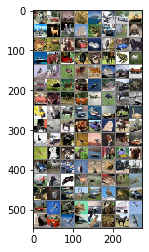

  cat truck   car  frog


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 5, padding = 2)
        self.pool = nn.MaxPool2d(3, stride = 2)
        self.conv2 = nn.Conv2d(64, 64, 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding = 2)
        self.fc1 = nn.Linear(1152, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 1152)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=10, step_size_down=10)

In [5]:
EPOCH = 45

train_loss = []
test_loss = []

train_acc = []
test_acc = []

lr = []

for epoch in range(EPOCH):  # loop over the dataset multiple times

    print('Epoch %d' % (epoch+1))
    print('learning rate :', optimizer.param_groups[0]['lr'])
    lr.append(optimizer.param_groups[0]['lr'])

    # loss for show
    running_loss = 0.0
    
    # loss for draw graph
    sum_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs.cuda()).cpu()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # print statistics
        sum_train_loss += loss.item()
        
    print('Accuracy of the network on the train images: %d %%' % (100 * train_correct / train_total))
            
    train_loss.append(sum_train_loss / train_total)
    train_acc.append(train_correct / train_total)
    
    # loss for draw graph
    sum_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.cuda()).cpu()
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            sum_loss += loss.item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    
    test_loss.append(sum_loss / total)
    test_acc.append(correct / total)

    # scheduler.step()
    # scheduler.step(loss)

    if train_correct / train_total >= 0.6 :
        for g in optimizer.param_groups:
            g['lr'] = 0.01
    

print('Finished Training')

Epoch 1
learning rate : 0.001
Accuracy of the network on the train images: 16 %
Accuracy of the network on the 10000 test images: 25 %
Epoch 2
learning rate : 0.001
Accuracy of the network on the train images: 29 %
Accuracy of the network on the 10000 test images: 34 %
Epoch 3
learning rate : 0.001
Accuracy of the network on the train images: 38 %
Accuracy of the network on the 10000 test images: 41 %
Epoch 4
learning rate : 0.001
Accuracy of the network on the train images: 43 %
Accuracy of the network on the 10000 test images: 44 %
Epoch 5
learning rate : 0.001
Accuracy of the network on the train images: 47 %
Accuracy of the network on the 10000 test images: 48 %
Epoch 6
learning rate : 0.001
Accuracy of the network on the train images: 50 %
Accuracy of the network on the 10000 test images: 52 %
Epoch 7
learning rate : 0.001
Accuracy of the network on the train images: 53 %
Accuracy of the network on the 10000 test images: 54 %
Epoch 8
learning rate : 0.001
Accuracy of the network o

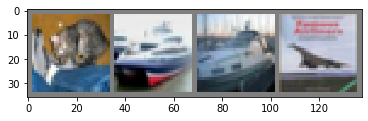

GroundTruth:    cat  ship  ship plane


In [6]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
outputs = net(images.cuda()).cpu()

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship truck plane


In [8]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda()).cpu()
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 84 %
Accuracy of  bird : 74 %
Accuracy of   cat : 59 %
Accuracy of  deer : 79 %
Accuracy of   dog : 66 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 86 %
Accuracy of truck : 84 %


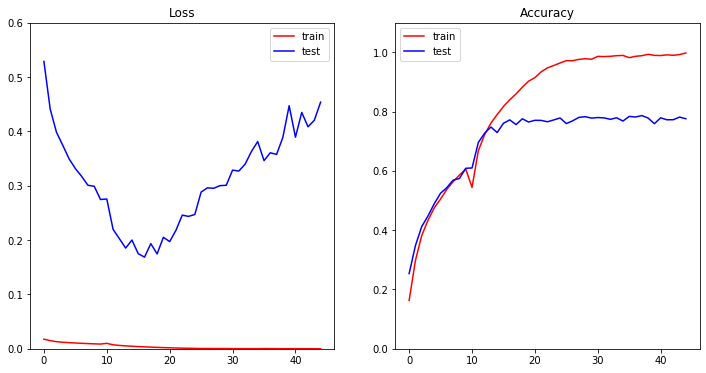

train_loss =  [0.017679167299270628, 0.015023606290817261, 0.013097776670455932, 0.012071283950805664, 0.011324661302566529, 0.010682268543243409, 0.01008015516757965, 0.00957652886390686, 0.009127762824296951, 0.008712741103172302, 0.0100223548579216, 0.00737683224439621, 0.006219099029302597, 0.005334706274271011, 0.004707527834773064, 0.004104145694971084, 0.003592845602631569, 0.003107924232780933, 0.0026374257072806356, 0.0021739897081255915, 0.0018871329060196876, 0.001461218018606305, 0.0011551711324602365, 0.0009829792477190494, 0.000805694994404912, 0.0006430764522589743, 0.0006208926027268171, 0.0005381410208903253, 0.0004984474405832588, 0.000521407717987895, 0.0003222045782674104, 0.00033214489156380297, 0.00031546873302664607, 0.000267209699251689, 0.0002445695519610308, 0.0003986735631618649, 0.00031443546618334947, 0.0002729324388550594, 0.00016360157014452852, 0.00023432956504868343, 0.0002469302461226471, 0.00019667823094176128, 0.0002417639996809885, 0.000176005514573

In [9]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(train_loss, c='r', label='train')
ax1.plot(test_loss, c='b', label='test')
ax2.plot(train_acc, c='r', label='train')
ax2.plot(test_acc, c='b', label='test')

ax1.title.set_text('Loss')
ax2.title.set_text('Accuracy')

ax1.set_ylim([0,0.6])
ax2.set_ylim([0,1.1])

ax1.legend()
ax2.legend()

plt.show()

print('_train = ', train_loss)
print('_test = ', test_loss)
print('_train_acc = ', train_acc)
print('_test_acc = ', test_acc)
print('_lr = ', lr)